In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [3]:
np.random.seed(0)

In [4]:
full_data = pd.read_csv("../input/commonlitreadabilityprize/train.csv")

In [5]:
excerpts = full_data["excerpt"]
target = full_data["target"]

In [6]:
excerpts = excerpts.str.lower()

**Performing Stemming**

In [7]:
#from nltk.stem import PorterStemmer
#ps = PorterStemmer()
#excerpts = excerpts.apply(ps.stem)

In [8]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
excerpts = excerpts.apply(wnl.lemmatize)

In [9]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
excerpts = excerpts.apply(lambda text: remove_stopwords(text))

In [10]:
excerpts_train, excerpts_val, y_train, y_val = train_test_split(excerpts, target, test_size=0.30)

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(excerpts_train)

CountVectorizer()

In [12]:
X_train = vectorizer.transform(excerpts_train)
X_val = vectorizer.transform(excerpts_val)
X_train.shape

(1983, 22435)

In [13]:
vec = TfidfVectorizer(max_features = 5000)
X_train = vec.fit_transform(excerpts_train).toarray()
X_val = vec.transform(excerpts_val).toarray()

In [14]:
dl_model = keras.Sequential([
  
    layers.Dense(units=1024, activation='relu', input_shape=[5000]),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dense(units=1),
])

dl_model.summary()


# Define an early stopping callback
early_stopping = callbacks.EarlyStopping(patience=20,min_delta=0.001,
                                        restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                       patience = 20, min_lr = 0.0001)


dl_model.compile(metrics = ['acc'],
    optimizer='adam',
    loss='mae',
)

history = dl_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=512,
    epochs=300,
    callbacks=[early_stopping]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              5121024   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,721,857
Trainable params: 5,721,857
Non-trainable params: 0
______________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  import sys


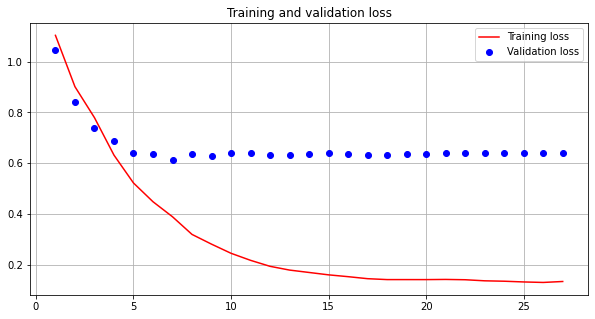

In [15]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'b', color='red', label='Training loss')
plt.plot(epochs, val_loss, 'bo',color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [16]:
readable_preds = dl_model.predict(X_val)
dl_val_mae = mean_absolute_error(y_val,readable_preds)
print("Validation MAE for Deep learning Model: {}".format(dl_val_mae))

Validation MAE for Deep learning Model: 0.6107591574028667


In [17]:
test_data = pd.read_csv("../input/commonlitreadabilityprize/test.csv")

In [18]:
test_excerpts = test_data["excerpt"]

In [19]:
test_excerpts = test_excerpts.str.lower()
#test_excerpts = test_excerpts.apply(ps.stem)
test_excerpts = test_excerpts.apply(wnl.lemmatize)
test_excerpts = test_excerpts.apply(lambda text: remove_stopwords(text))

In [20]:
X_test = vectorizer.transform(test_excerpts)

In [21]:
X_test = vec.transform(test_excerpts).toarray()

In [22]:
test_preds = dl_model.predict(X_test)

In [23]:
x_sub = test_data[["id"]].copy()
x_sub["target"] = test_preds
x_sub.to_csv('submission.csv', index = False)
x_sub

,id,target
0,c0f722661,-1.488201
1,f0953f0a5,-0.415445
2,0df072751,-0.594510
3,04caf4e0c,-1.453715
4,0e63f8bea,-1.402604
5,12537fe78,-0.611850
6,965e592c0,-0.414111
